# 데이터 머신러닝 분석
-> dtc, rfa 사용하여 feature_importance 및 f1_score 분석

-> 외감 데이터 + 휴폐업데이터 기준 재무데이터에 사업자번호 기준으로 라벨링 후 머지

-> 네이버 데이터 트렌드 검색결과 추가 후 분석

In [2]:
# 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
import seaborn as sns
# 한글
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm , rc
font = fm.FontProperties(fname='C:\Windows\Fonts/gulim.ttc').get_name()

In [3]:
# 산업 추가된 파일 불러오기
nb_active_out = pd.read_excel('액티브_중소법인_기업외감_산업분류.xlsx')
nb_deactive_ind = pd.read_excel('휴폐업_중소법인_기업개요_산업분류.xlsx')
nb_finance_data = pd.read_csv('재무데이터.txt', encoding='cp949', sep='\t')


In [4]:
# 액티브 / 휴폐업 구분
nb_active_out['target'] = '0'
nb_deactive_ind['target'] = '1'

In [5]:
# 사업자 번호로 재무데이터 그룹
financ_gr = nb_finance_data.groupby('사업자번호')[nb_finance_data.columns].mean()
del financ_gr['사업자번호']
financ_gr = financ_gr.reset_index()
financ_gr

,사업자번호,결산년월,유동자산,매출채권,비유동자산,유형자산,자산총계,유동부채,비유동부채,부 채 총 계,...,비유동부채비율(%),부채총계대 매출액(%),총자본회전율(회),재고자산회전율(회),매출채권회전율(회),매입채무회전율(회),미수금,매출원가,무형자산,재고자산
0,1018100340,20196231.0,2.070964e+06,1.433848e+05,3.549089e+07,1.118161e+06,3.756186e+07,5.333542e+06,1.045350e+07,1.578704e+07,...,4.943925e+01,2.503123e+02,1.642500e-01,1.000000e+12,5.171175e+01,1.000000e+12,3243.000000,NaN,NaN,NaN
1,1018100772,20196231.0,4.828732e+05,1.218333e+04,2.089307e+07,2.088182e+07,2.137594e+07,3.142721e+06,1.204274e+07,1.518546e+07,...,1.971870e+02,2.489536e+03,3.875000e-02,1.000000e+12,2.500000e+11,1.000000e+12,441694.500000,5.181350e+05,NaN,NaN
2,1018101126,20196231.0,1.491190e+06,1.021362e+05,3.550742e+07,3.435322e+07,3.699861e+07,8.974535e+06,3.180149e+06,1.215468e+07,...,1.280500e+01,4.684630e+02,8.025000e-02,1.000000e+12,2.581250e+01,1.000000e+12,902.750000,1.516039e+06,527.5,NaN
3,1018101242,20196231.0,5.428135e+05,1.440118e+05,2.465907e+07,2.200939e+07,2.520188e+07,6.706615e+06,2.318500e+06,9.025115e+06,...,1.437100e+01,3.380270e+02,1.075000e-01,1.000000e+12,1.859625e+01,1.000000e+12,NaN,1.178152e+06,NaN,NaN
4,1018103819,20196231.0,1.667547e+06,4.804125e+04,1.150967e+07,1.108649e+07,1.317722e+07,6.715410e+06,1.568218e+06,8.283628e+06,...,3.203725e+01,7.660750e+02,8.225000e-02,1.000000e+12,2.059725e+01,1.000000e+12,12500.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35704,8998700283,20186231.0,1.008218e+06,4.940150e+05,2.950450e+05,2.750500e+04,1.303263e+06,2.843760e+05,1.480000e+05,4.323760e+05,...,1.701150e+01,1.476500e+01,2.181500e+00,5.713500e+00,8.110500e+00,1.325500e+01,NaN,2.736914e+06,NaN,340673.00
35705,8998701263,20191231.0,9.025398e+06,NaN,NaN,NaN,9.025398e+06,1.655333e+03,7.272607e+05,7.289157e+05,...,8.774000e+00,9.444444e+11,3.333333e+11,1.000000e+12,1.000000e+12,1.000000e+12,NaN,NaN,NaN,NaN
35706,8998800150,20196231.0,8.987382e+06,1.454567e+06,2.287665e+07,1.850289e+07,3.186404e+07,1.800650e+07,1.739726e+06,1.974623e+07,...,1.523050e+01,6.216600e+01,1.053750e+00,8.888400e+01,2.279075e+01,1.078650e+01,6738.750000,1.384895e+06,105701.5,416709.00
35707,8998800427,20196231.0,7.198705e+06,2.728476e+06,7.227014e+06,6.594312e+06,1.442572e+07,7.778158e+06,4.469290e+06,1.224745e+07,...,2.438800e+02,2.500000e+11,2.500000e+11,2.500000e+11,2.500000e+11,2.500000e+11,321181.333333,1.542906e+07,442612.0,2826866.75


In [6]:
# 재무데이터 파일에 휴폐업 정보 머지
financ_merge = pd.merge(financ_gr, nb_active_out[['BIZ_NO', 'target']], how='left', left_on='사업자번호',right_on='BIZ_NO')
financ_merge = pd.merge(financ_merge, nb_deactive_ind[['BIZ_NO', 'target']], how='left', left_on='사업자번호',right_on='BIZ_NO')
financ_merge

,사업자번호,결산년월,유동자산,매출채권,비유동자산,유형자산,자산총계,유동부채,비유동부채,부 채 총 계,...,매출채권회전율(회),매입채무회전율(회),미수금,매출원가,무형자산,재고자산,BIZ_NO_x,target_x,BIZ_NO_y,target_y
0,1018100340,20196231.0,2.070964e+06,1.433848e+05,3.549089e+07,1.118161e+06,3.756186e+07,5.333542e+06,1.045350e+07,1.578704e+07,...,5.171175e+01,1.000000e+12,3243.000000,NaN,NaN,NaN,1.018100e+09,0,NaN,NaN
1,1018100772,20196231.0,4.828732e+05,1.218333e+04,2.089307e+07,2.088182e+07,2.137594e+07,3.142721e+06,1.204274e+07,1.518546e+07,...,2.500000e+11,1.000000e+12,441694.500000,5.181350e+05,NaN,NaN,1.018101e+09,0,NaN,NaN
2,1018101126,20196231.0,1.491190e+06,1.021362e+05,3.550742e+07,3.435322e+07,3.699861e+07,8.974535e+06,3.180149e+06,1.215468e+07,...,2.581250e+01,1.000000e+12,902.750000,1.516039e+06,527.5,NaN,1.018101e+09,0,NaN,NaN
3,1018101242,20196231.0,5.428135e+05,1.440118e+05,2.465907e+07,2.200939e+07,2.520188e+07,6.706615e+06,2.318500e+06,9.025115e+06,...,1.859625e+01,1.000000e+12,NaN,1.178152e+06,NaN,NaN,1.018101e+09,0,NaN,NaN
4,1018103819,20196231.0,1.667547e+06,4.804125e+04,1.150967e+07,1.108649e+07,1.317722e+07,6.715410e+06,1.568218e+06,8.283628e+06,...,2.059725e+01,1.000000e+12,12500.000000,NaN,NaN,NaN,1.018104e+09,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35704,8998700283,20186231.0,1.008218e+06,4.940150e+05,2.950450e+05,2.750500e+04,1.303263e+06,2.843760e+05,1.480000e+05,4.323760e+05,...,8.110500e+00,1.325500e+01,NaN,2.736914e+06,NaN,340673.00,NaN,NaN,8.998700e+09,1
35705,8998701263,20191231.0,9.025398e+06,NaN,NaN,NaN,9.025398e+06,1.655333e+03,7.272607e+05,7.289157e+05,...,1.000000e+12,1.000000e+12,NaN,NaN,NaN,NaN,NaN,NaN,8.998701e+09,1
35706,8998800150,20196231.0,8.987382e+06,1.454567e+06,2.287665e+07,1.850289e+07,3.186404e+07,1.800650e+07,1.739726e+06,1.974623e+07,...,2.279075e+01,1.078650e+01,6738.750000,1.384895e+06,105701.5,416709.00,8.998800e+09,0,NaN,NaN
35707,8998800427,20196231.0,7.198705e+06,2.728476e+06,7.227014e+06,6.594312e+06,1.442572e+07,7.778158e+06,4.469290e+06,1.224745e+07,...,2.500000e+11,2.500000e+11,321181.333333,1.542906e+07,442612.0,2826866.75,8.998800e+09,0,NaN,NaN


In [7]:
# 휴폐업 비율 확인
financ_merge.target_y.value_counts(), financ_merge.target_x.value_counts()

(1    6731
 Name: target_y, dtype: int64,
 0    28978
 Name: target_x, dtype: int64)

In [8]:
# NaN 값 처리 및 결과 확인
financ_merge.target_x.fillna('', inplace=True)
financ_merge.target_y.fillna('', inplace=True)
financ_merge['target'] = financ_merge.target_x + financ_merge.target_y
financ_merge['target'].value_counts()

0    28978
1     6731
Name: target, dtype: int64

In [9]:
# 액티브 외감 / 휴폐업 아닌 정보들 drop
financ_merge = financ_merge.drop(financ_merge[financ_merge.target == ''].index)
financ_merge = financ_merge[financ_merge.columns.drop(['BIZ_NO_x', 'target_x', 'BIZ_NO_y', 'target_y', '사업자번호', '결산년월'])]
financ_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35709 entries, 0 to 35708
Data columns (total 45 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   유동자산          35443 non-null  float64
 1   매출채권          30800 non-null  float64
 2   비유동자산         35126 non-null  float64
 3   유형자산          33388 non-null  float64
 4   자산총계          35447 non-null  float64
 5   유동부채          35398 non-null  float64
 6   비유동부채         32563 non-null  float64
 7   부  채  총  계    35422 non-null  float64
 8   자본금           35432 non-null  float64
 9   이익잉여금(결손금）    35322 non-null  float64
 10  자본총계          35445 non-null  float64
 11  매출액           34333 non-null  float64
 12  판매비와관리비       35301 non-null  float64
 13  영업이익（손실）      35416 non-null  float64
 14  법인세비용차감전순손익   35320 non-null  float64
 15  법인세비용         27293 non-null  float64
 16  당기순이익(손실)     35428 non-null  float64
 17  기업순이익률(%)     35709 non-null  float64
 18  유보액/총자산(%)    35705 non-nu

In [10]:
# 재무 결측치 평균값으로 처리 / NaN 값 확인
for var in financ_merge.columns[:-1] :
    financ_merge[var].fillna(financ_merge[var].mean(), inplace=True)
financ_merge.isna().sum().sum()

0

In [34]:
#  train_test_split
X_train, X_test, y_train, y_test = train_test_split(financ_merge[financ_merge.columns[:-1]], financ_merge.target,test_size=0.2, stratify=financ_merge.target, random_state=2022)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28567, 44), (7142, 44), (28567,), (7142,))

## 머신러닝 분석
-> 재무데이터에 외감 / 휴폐업 데이터를 머지하여 사용

-> feature_importances 및 f1_score pos_label = 휴폐업 정확도 파악 목적

In [35]:
# 의사결정나무 모델
dtc = DecisionTreeClassifier(random_state=2022).fit(X_train, y_train)
dtc.score(X_test, y_test)

0.9215905908709046

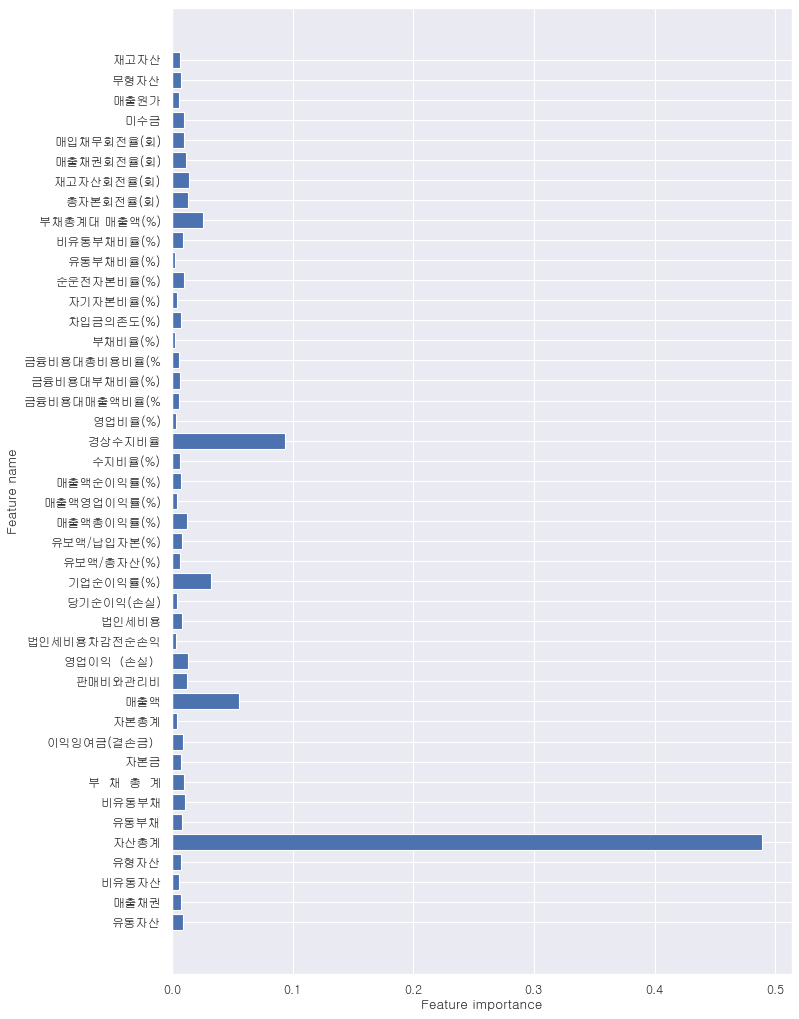

In [36]:
# 의사결정 나무 모델 feature_importances
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm , rc
font = fm.FontProperties(fname='C:\Windows\Fonts/gulim.ttc').get_name()
rc('font', family=font)
plt.figure(figsize=(10,16), dpi=80)
c_features = len(X_train.columns)
plt.barh(range(c_features), dtc.feature_importances_)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(c_features), X_train.columns)
plt.show()

<AxesSubplot:>

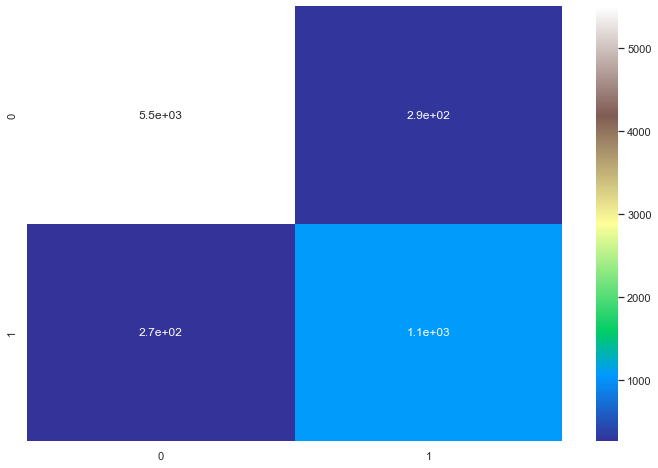

In [37]:
# dtc ClassificationReport
c = financ_merge.target.astype('category')
targets = dict(enumerate(c.cat.categories))
from sklearn.metrics import confusion_matrix
mat=confusion_matrix(y_test,dtc.predict(X_test))
df_cm = pd.DataFrame(mat, list(targets.values()), list(targets.values()))
sns.set(font_scale=1.0) # for label size
plt.figure(figsize = (12,8))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12},cmap="terrain")

랜덤포레스트 정확도  :  0.9467936152338281


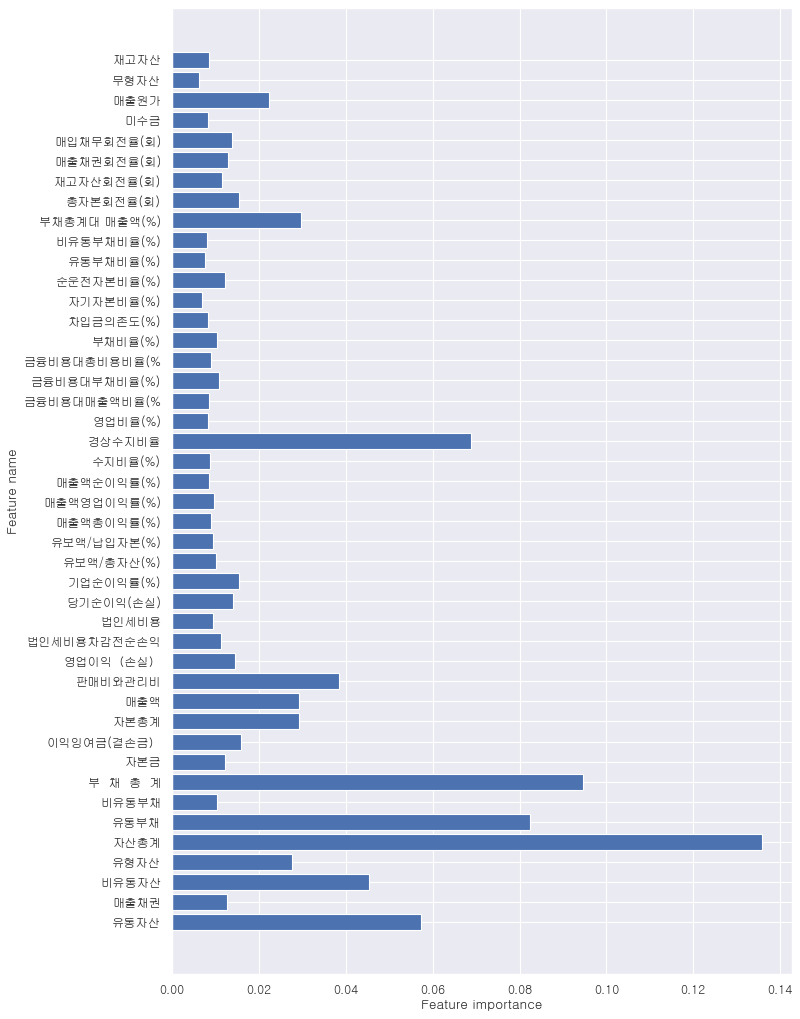

In [38]:
# 랜덤포레스트
rfc = RandomForestClassifier(random_state=2022).fit(X_train, y_train)
print('랜덤포레스트 정확도  : ' ,rfc.score(X_test, y_test))
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm , rc
font = fm.FontProperties(fname='C:\Windows\Fonts/gulim.ttc').get_name()
rc('font', family=font)
plt.figure(figsize=(10,16), dpi=80)
c_features = len(X_train.columns)
plt.barh(range(c_features), rfc.feature_importances_)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(c_features), X_train.columns)
plt.show()

In [39]:
# 휴폐업에 대한 f1_score
pred = rfc.predict(X_test)
f1_score(y_test, pred, pos_label='1')

0.8447712418300654

## 재무데이터에 네이버 트렌드 데이터 추가하여 분석
-> DecisionTree, RandomForest 동일하게 사용

In [11]:
# 네이버 트렌드 데이터 호출
df_actice_naver = pd.read_csv('네이버_데이터_트렌드\네이버_데이터_트렌드_통합_액티브_외감_28979.csv')
df_deactice_naver = pd.read_csv('네이버_데이터_트렌드\네이버_데이터_트렌드_통합_휴폐업_6739.csv')

In [12]:
# 액티브 / 휴폐업 구분
scaler = MinMaxScaler()
df_actice_naver['target'] = '0'
df_deactice_naver['target'] = '1'
financ_naver_merge = pd.merge(financ_gr, df_actice_naver[['BIZ_NO', 'mean', 'target']], how='left', left_on='사업자번호',right_on='BIZ_NO')
financ_naver_merge = pd.merge(financ_naver_merge, df_deactice_naver[['BIZ_NO', 'mean', 'target']], how='left', left_on='사업자번호',right_on='BIZ_NO')
# NaN 값 처리 및 결과 확인 naver_mean
financ_naver_merge.mean_x.fillna(0, inplace=True)
financ_naver_merge.mean_y.fillna(0, inplace=True)
financ_naver_merge['naver_mean'] = financ_naver_merge.mean_x + financ_naver_merge.mean_y
# MinMaxScaler 이용 스케일링 해줌
financ_naver_merge['naver_mean'] = scaler.fit_transform(financ_naver_merge[['naver_mean']])
# NaN 값 처리 및 결과 확인 target
financ_naver_merge.target_x.fillna('', inplace=True)
financ_naver_merge.target_y.fillna('', inplace=True)
financ_naver_merge['target'] = financ_naver_merge.target_x + financ_naver_merge.target_y
# 액티브 외감 / 휴폐업 아닌 정보들 drop
financ_naver_merge = financ_naver_merge.drop(financ_naver_merge[financ_naver_merge.target == ''].index)
financ_naver_merge = financ_naver_merge.drop(financ_naver_merge[financ_naver_merge.naver_mean == 0].index)
financ_naver_merge = financ_naver_merge[financ_naver_merge.columns.drop(['BIZ_NO_x', 'target_x', 'mean_x', 'mean_y','BIZ_NO_y', 'target_y', '사업자번호', '결산년월'])]
# 재무 결측치 평균값으로 처리 / NaN 값 확인
for var in financ_naver_merge.columns[:-1] :
    financ_naver_merge[var].fillna(financ_naver_merge[var].mean(), inplace=True)
print('NaN 값 개수 : ', financ_naver_merge.isna().sum().sum())
financ_naver_merge.info(), financ_naver_merge.target.value_counts()

NaN 값 개수 :  0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 34414 entries, 0 to 35708
Data columns (total 46 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   유동자산          34414 non-null  float64
 1   매출채권          34414 non-null  float64
 2   비유동자산         34414 non-null  float64
 3   유형자산          34414 non-null  float64
 4   자산총계          34414 non-null  float64
 5   유동부채          34414 non-null  float64
 6   비유동부채         34414 non-null  float64
 7   부  채  총  계    34414 non-null  float64
 8   자본금           34414 non-null  float64
 9   이익잉여금(결손금）    34414 non-null  float64
 10  자본총계          34414 non-null  float64
 11  매출액           34414 non-null  float64
 12  판매비와관리비       34414 non-null  float64
 13  영업이익（손실）      34414 non-null  float64
 14  법인세비용차감전순손익   34414 non-null  float64
 15  법인세비용         34414 non-null  float64
 16  당기순이익(손실)     34414 non-null  float64
 17  기업순이익률(%)     34414 non-null  float64
 18  유보액/총자산(%)  

(None,
 0    28130
 1     6284
 Name: target, dtype: int64)

NaN 값 개수 :  0
스케일 안된 네이버 트렌드 평균 값 : 24.341459101338973


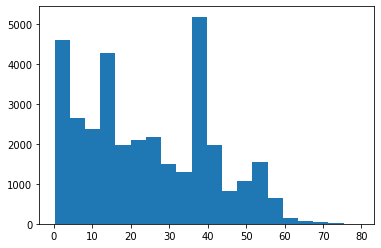

In [27]:
# 스케일 안된 값 분포
df_actice_naver['target'] = '0'
df_deactice_naver['target'] = '1'
financ_naver_merge_n_sc = pd.merge(financ_gr, df_actice_naver[['BIZ_NO', 'mean', 'target']], how='left', left_on='사업자번호',right_on='BIZ_NO')
financ_naver_merge_n_sc = pd.merge(financ_naver_merge_n_sc, df_deactice_naver[['BIZ_NO', 'mean', 'target']], how='left', left_on='사업자번호',right_on='BIZ_NO')
# NaN 값 처리 및 결과 확인 naver_mean
financ_naver_merge_n_sc.mean_x.fillna(0, inplace=True)
financ_naver_merge_n_sc.mean_y.fillna(0, inplace=True)
financ_naver_merge_n_sc['naver_mean'] = financ_naver_merge_n_sc.mean_x + financ_naver_merge_n_sc.mean_y
# NaN 값 처리 및 결과 확인 target
financ_naver_merge_n_sc.target_x.fillna('', inplace=True)
financ_naver_merge_n_sc.target_y.fillna('', inplace=True)
financ_naver_merge_n_sc['target'] = financ_naver_merge_n_sc.target_x + financ_naver_merge_n_sc.target_y
# 액티브 외감 / 휴폐업 아닌 정보들 drop
financ_naver_merge_n_sc = financ_naver_merge_n_sc.drop(financ_naver_merge_n_sc[financ_naver_merge_n_sc.target == ''].index)
financ_naver_merge_n_sc = financ_naver_merge_n_sc.drop(financ_naver_merge_n_sc[financ_naver_merge_n_sc.naver_mean == 0].index)
financ_naver_merge_n_sc = financ_naver_merge_n_sc[financ_naver_merge_n_sc.columns.drop(['BIZ_NO_x', 'target_x', 'mean_x', 'mean_y','BIZ_NO_y', 'target_y', '사업자번호', '결산년월'])]
# 재무 결측치 평균값으로 처리 / NaN 값 확인
for var in financ_naver_merge_n_sc.columns[:-1] :
    financ_naver_merge_n_sc[var].fillna(financ_naver_merge_n_sc[var].mean(), inplace=True)
print('NaN 값 개수 : ', financ_naver_merge_n_sc.isna().sum().sum())
# financ_naver_merge_n_sc.info(), financ_naver_merge_n_sc.target.value_counts()
# 스케일링 된 값 분포
print('스케일 안된 네이버 트렌드 평균 값 :', financ_naver_merge_n_sc.naver_mean.mean())
plt.hist(financ_naver_merge_n_sc.naver_mean, bins=20)
plt.show()

In [14]:
# 스케일링된 값 평균
financ_naver_merge.naver_mean.mean()

0.3068251090715552

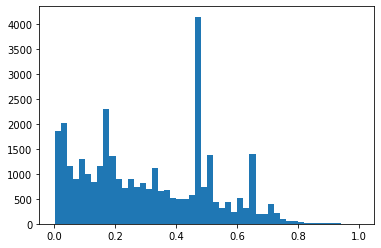

In [17]:
# 스케일링 된 네이버 트렌드 값 분포
plt.hist(financ_naver_merge.naver_mean, bins=50)
plt.show()

In [29]:
#  train_test_split
X_naver_train, X_naver_test, y_naver_train, y_naver_test = train_test_split(financ_naver_merge[financ_naver_merge.columns[:-1]], financ_naver_merge.target,test_size=0.2, stratify=financ_naver_merge.target, random_state=2022)
X_naver_train.shape, X_naver_test.shape, y_naver_train.shape, y_naver_test.shape

((27531, 45), (6883, 45), (27531,), (6883,))

의사결정 나무 모델 정확도 :  0.9216911230568067


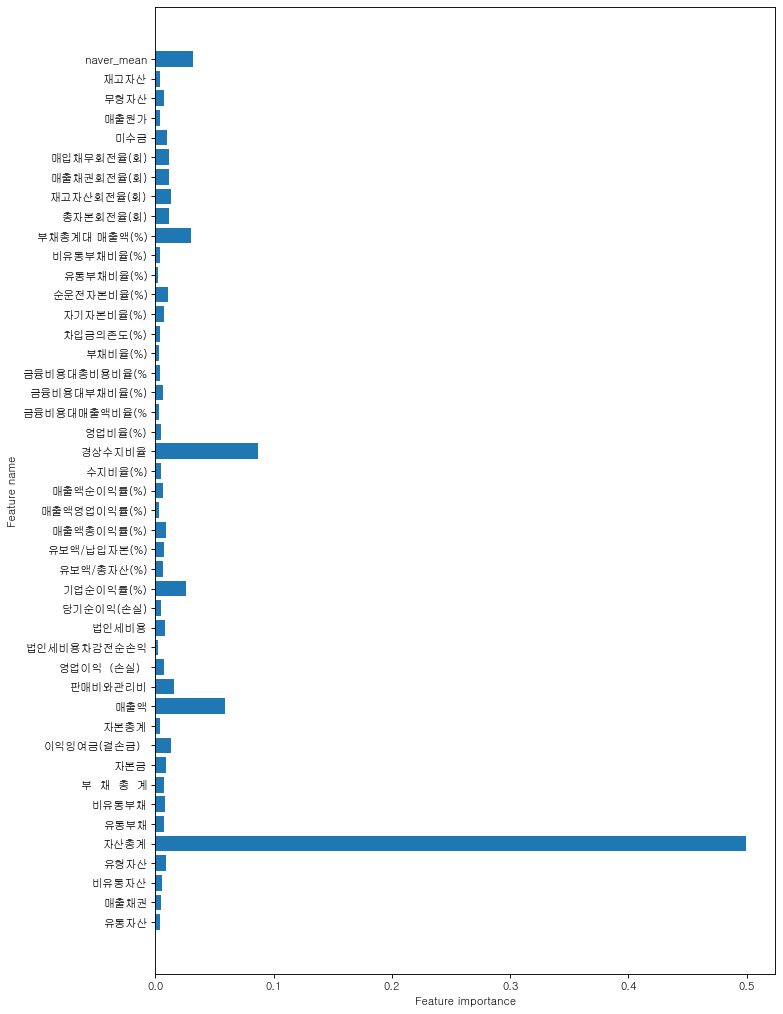

In [30]:
# 의사결정나무 모델
dtc_naver = DecisionTreeClassifier(random_state=2022).fit(X_naver_train, y_naver_train)
print( '의사결정 나무 모델 정확도 : ', dtc_naver.score(X_naver_test, y_naver_test))
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm , rc
font = fm.FontProperties(fname='C:\Windows\Fonts/gulim.ttc').get_name()
rc('font', family=font)
plt.figure(figsize=(10,16), dpi=80)
c_features = len(X_naver_train.columns)
plt.barh(range(c_features), dtc_naver.feature_importances_)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(c_features), X_naver_train.columns)
plt.show()


In [31]:
# 휴폐업에 대한 f1_score
pred = dtc_naver.predict(X_naver_test)
f1_score(y_naver_test, pred, pos_label='1')

0.7865346534653467

랜덤포레스트 정확도  :  0.9434839459537993


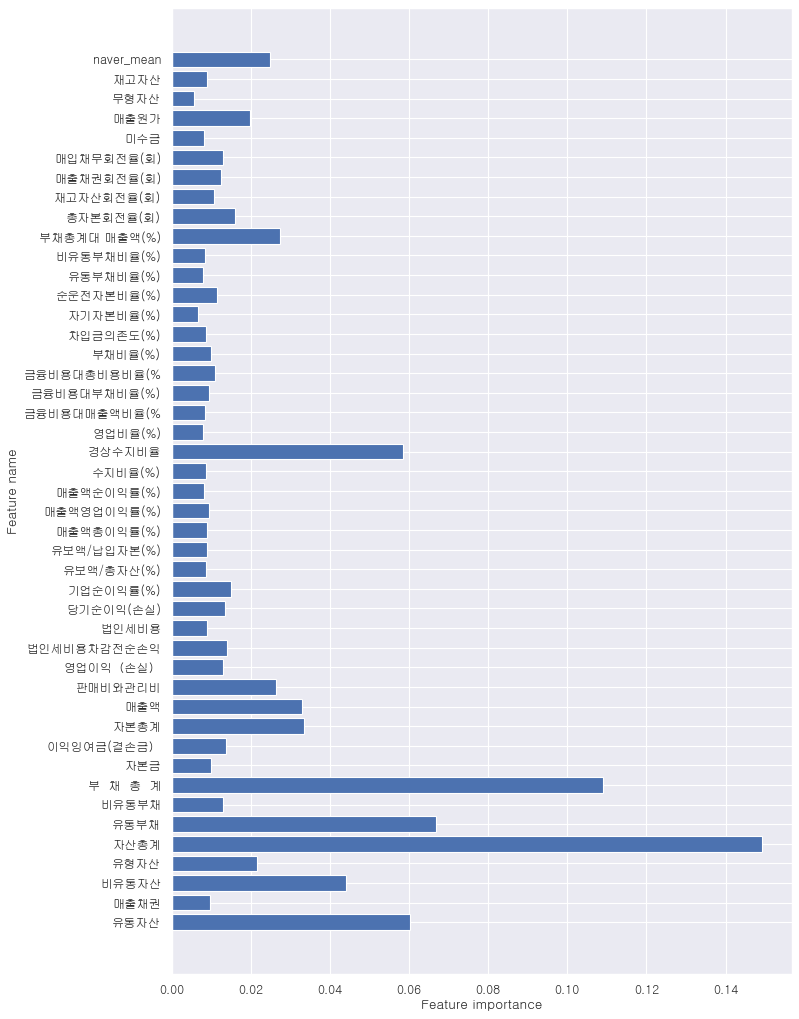

In [92]:
# 랜덤포레스트
rfc_naver = RandomForestClassifier(random_state=2022).fit(X_naver_train, y_naver_train)
print('랜덤포레스트 정확도  : ' ,rfc_naver.score(X_naver_test, y_naver_test))
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm , rc
font = fm.FontProperties(fname='C:\Windows\Fonts/gulim.ttc').get_name()
rc('font', family=font)
plt.figure(figsize=(10,16), dpi=80)
c_features = len(X_naver_train.columns)
plt.barh(range(c_features), rfc_naver.feature_importances_)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(c_features), X_naver_train.columns)
plt.show()

In [98]:
pred = rfc_naver.predict(X_naver_test)
f1_score(y_naver_test, pred, pos_label='1')

0.8270342374388617

In [99]:
# 연관성 분석
financ_naver_merge.target = financ_naver_merge.target.astype('int64')
financ_naver_merge[['naver_mean', 'target']].corr()['target'].drop('target')

naver_mean   -0.097444
Name: target, dtype: float64

In [95]:
form1 = 'target~naver_mean'
lr1 = ols(form1, financ_naver_merge).fit()
lr1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     329.9
Date:                Mon, 24 Oct 2022   Prob (F-statistic):           2.24e-73
Time:                        14:09:54   Log-Likelihood:                -15938.
No. Observations:               34414   AIC:                         3.188e+04
Df Residuals:                   34412   BIC:                         3.190e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2387      0.004     64.195      0.000       0.231       0.246
naver_mean    -0.1827      0.010    -18.163      0.000      -0.202      -0.163
==============================================================================
Omnibus:                     8299.556   Durbin-Watson:                   1.810
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15782.191
Skew:                           1.622   Prob(JB):                         0.00
Kurtosis:                       3.694   Cond. No.                         5.33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

랜덤포레스트 정확도  :  0.9433386604678192
f1_score_휴폐업 정확도 : 0.8257372654155496


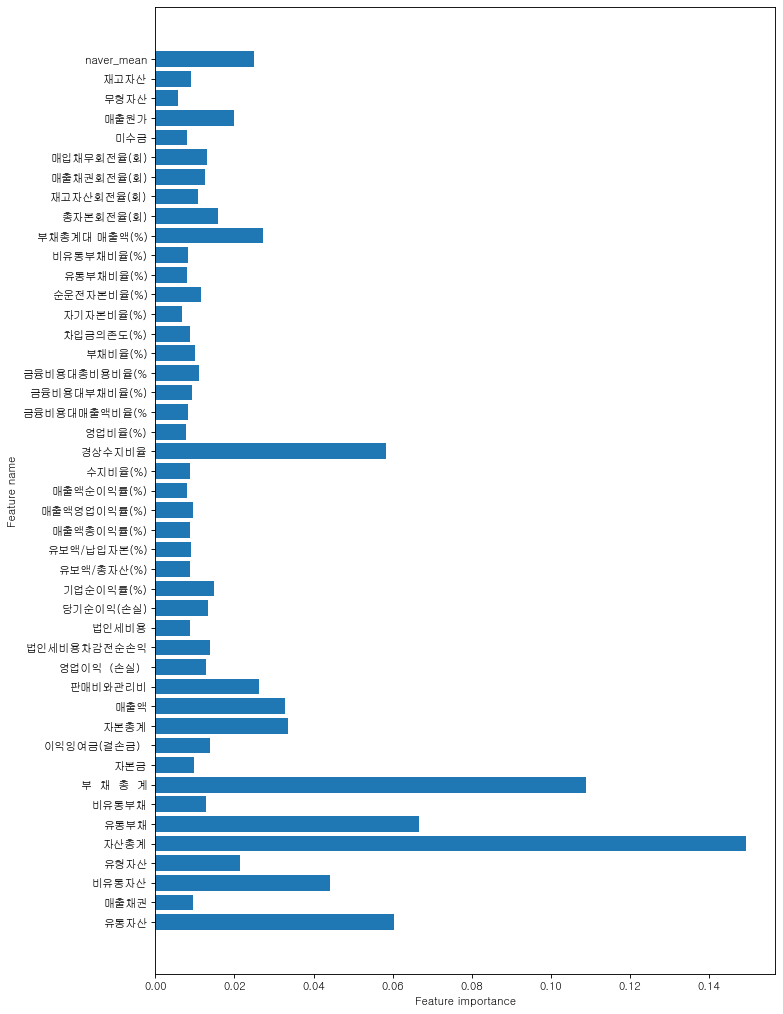

In [38]:
# 네이버 트렌드 검색량이 10 이상인 데이터로만 예측
financ_naver_merge_n_sc[financ_naver_merge_n_sc['naver_mean'] >= 10]
X_naver_train_nsc, X_naver_test_nsc, y_naver_train_nsc, y_naver_test_nsc = train_test_split(financ_naver_merge_n_sc[financ_naver_merge_n_sc.columns[:-1]], financ_naver_merge_n_sc.target,test_size=0.2, stratify=financ_naver_merge_n_sc.target, random_state=2022)
rfc_naver_ncs = RandomForestClassifier(random_state=2022).fit(X_naver_train_nsc, y_naver_train_nsc)
print('랜덤포레스트 정확도  : ' ,rfc_naver_ncs.score(X_naver_test_nsc, y_naver_test_nsc))
pred = rfc_naver_ncs.predict(X_naver_test)
print('f1_score_휴폐업 정확도 :', f1_score(y_naver_test, pred, pos_label='1'))
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm , rc
font = fm.FontProperties(fname='C:\Windows\Fonts/gulim.ttc').get_name()
rc('font', family=font)
plt.figure(figsize=(10,16), dpi=80)
c_features = len(X_naver_train_nsc.columns)
plt.barh(range(c_features), rfc_naver_ncs.feature_importances_)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(c_features), X_naver_train_nsc.columns)
plt.show()